In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [32]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df_cancer = data.frame
df_cancer.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Salteo el análisis ya que es un dataset que conocemos
# Preprocesamiento de datos

In [33]:
def preparacion_de_datos(df_input, target, escalar_valores=False):
  df = df_input #.drop(['Close Approach Date','Orbit Determination Date'],axis=1)
  if escalar_valores: # and flag_que_hay_que_borrar:
    scaler_X = StandardScaler(with_mean=True, with_std=True)
    scaler_X.fit(df.drop(target,axis=1))
    x = pd.DataFrame(scaler_X.transform(df.drop(target,axis=1),), columns = df.drop(target,axis=1).columns )
  else:
    x = df.drop(target,axis=1)
  y = df[target]
  return x,y

In [34]:
X_cancer, y_cancer = preparacion_de_datos( df_cancer, "target" ,escalar_valores=False)

In [35]:
# Hacemos el Split 70-30 para train-test
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer,
                                                    test_size=0.3, stratify = y_cancer, random_state=0)

# Comparamos por curva ROC los modelos

In [36]:
def graficarCurvaRoc( y_pred, model ):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  # Graficamos
  plt.plot(fpr,tpr,label= model +" AUC="+str(round(auc,4))) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)
  return auc

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)

treeclf = DecisionTreeClassifier(max_depth=10, random_state=1)
treeclf.fit(X_train, y_train)
y_pred_tc = treeclf.predict(X_test)

bayes_multi = MultinomialNB()
bayes_multi.fit(X_train, y_train)
y_pred_nb = bayes_multi.predict(X_test)

bayes_gauss = GaussianNB()
bayes_gauss.fit(X_train, y_train)
y_pred_gauss = bayes_gauss.predict(X_test)

knn = DecisionTreeClassifier(max_depth=10, random_state=1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# y con el dataset escalado
X_cancer, y_cancer = preparacion_de_datos(df_cancer, "target", escalar_valores=True)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer,
                                                    test_size=0.3, stratify = y_cancer, random_state=0)
logreg_s = LogisticRegression()
logreg_s.fit(X_train, y_train)
y_pred_lg_s = logreg_s.predict(X_test)

bayes_gauss_s = GaussianNB()
bayes_gauss_s.fit(X_train, y_train)
y_pred_gauss_s = bayes_gauss_s.predict(X_test)

knn_s = DecisionTreeClassifier(max_depth=10, random_state=1)
knn_s.fit(X_train, y_train)
y_pred_knn_s = knn_s.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


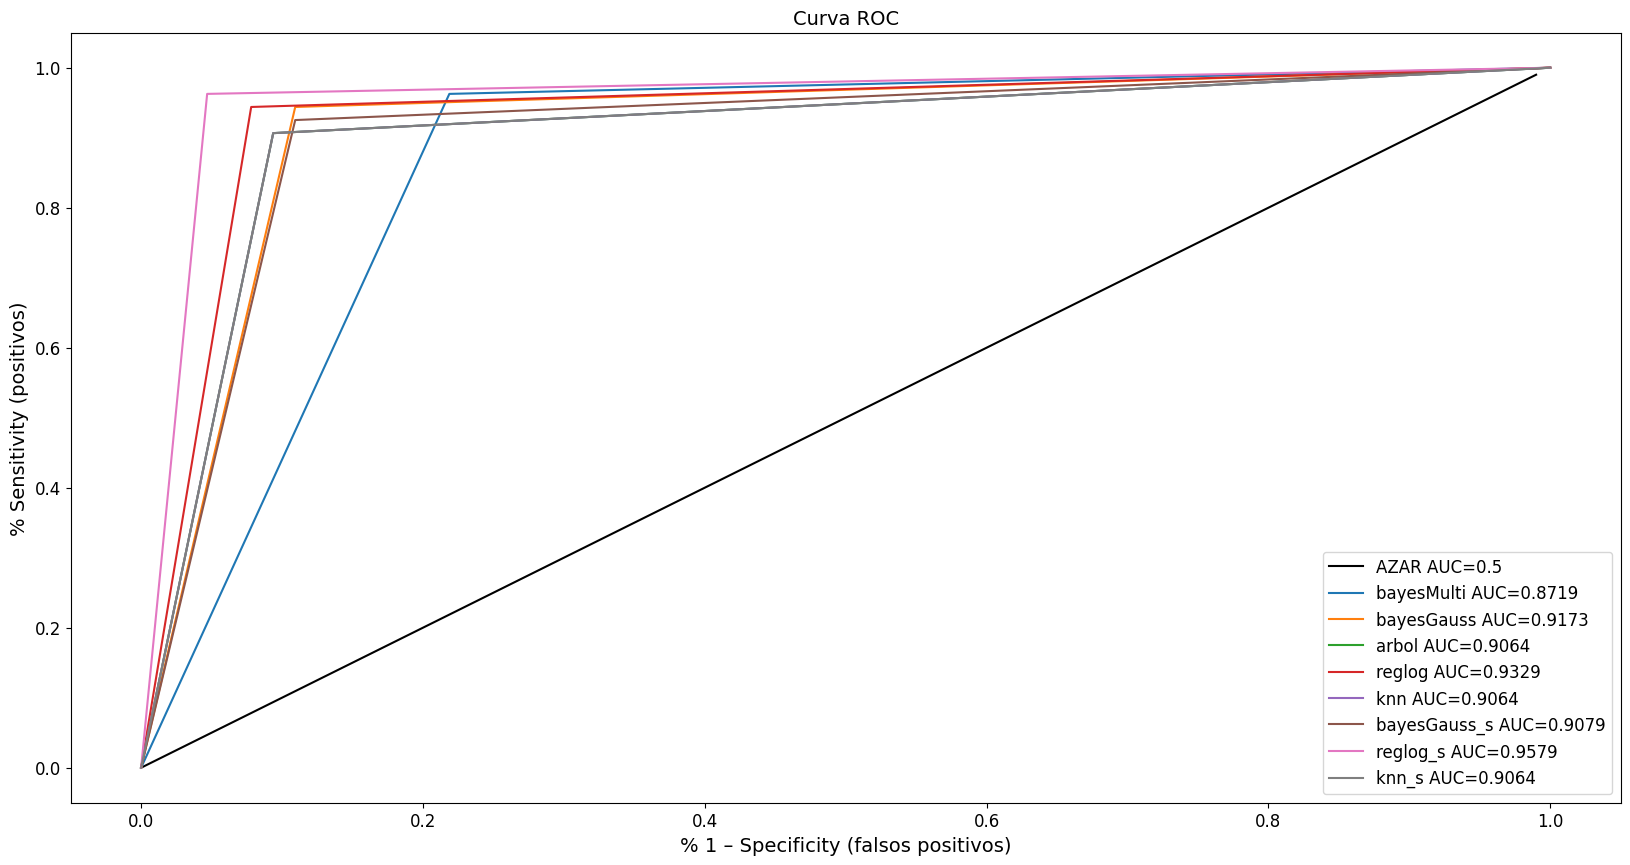

In [38]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'bayesMulti':y_pred_nb, 'bayesGauss':y_pred_gauss,'arbol':y_pred_tc,
           'reglog':y_pred_lg,'knn':y_pred_knn, 'bayesGauss_s':y_pred_gauss_s,
           'reglog_s':y_pred_lg_s,'knn_s':y_pred_knn_s,
           }
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

In [40]:
areas.sort_values('auc', ascending=False)

,model,auc
6,reglog_s,0.957871
3,reglog,0.932900
1,bayesGauss,0.917275
5,bayesGauss_s,0.907929
2,arbol,0.906396
4,knn,0.906396
7,knn_s,0.906396
0,bayesMulti,0.871933


# Mejoramos el modelo elegido con GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = { ____ }
clf = GridSearchCV( _____ , parameters)
clf.fit(X_train, y_train)